In [1]:
import torch as th
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import numpy as np

In [41]:
class Net(nn.Module):
    
    def __init__(self, input_dim, num_inputs, hidden_dim):
        super(Net, self).__init__()
        
        self.num_inputs = num_inputs

        # Adjust the selector to consider all inputs
        self.selector = nn.Sequential(
            nn.Linear(input_dim * num_inputs, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_inputs)
        )
        
        # Policy remains the same but is applied to each input
        self.policy = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )
        
    def forward(self, *inputs, temperature=1.0):
        # Concatenate all inputs for the selector
        concatenated_inputs = th.cat(inputs, dim=-1)
        selector_logits = self.selector(concatenated_inputs)
        
        # Apply Gumbel-Softmax trick to selector logits
        gumbel_noise = -th.log(-th.log(th.rand_like(selector_logits)))
        sampled = F.softmax((selector_logits + gumbel_noise) / temperature, dim=-1)

        # Straight-Through Estimator: hard in forward, soft in backward
        hard_sampled = th.zeros_like(sampled).scatter_(-1, sampled.max(dim=-1, keepdim=True)[1], 1.0)
        hard_sampled = (hard_sampled - sampled).detach() + sampled

        # Process all inputs through the policy network in one batch
        stacked_inputs = th.stack(inputs, dim=1)
        # print(stacked_inputs)
        # print(stacked_inputs.shape)
        # print(hard_sampled)
        # print(hard_sampled.shape)
        # print((stacked_inputs * hard_sampled.unsqueeze(-1)).sum(1))
        # concatenated_policy_inputs = stacked_inputs.view(-1, stacked_inputs.shape[-1])
        concatenated_policy_inputs = (stacked_inputs * hard_sampled.unsqueeze(-1)).sum(1)
        # print(concatenated_policy_inputs.shape)
        concatenated_policy_outputs = self.policy(concatenated_policy_inputs)

        # Reshape policy outputs
        # policy_outputs = concatenated_policy_outputs.view(-1, len(inputs), *concatenated_policy_outputs.shape[1:])
        
        # Apply weights and sum
        # weighted_policy_outputs = policy_outputs * hard_sampled.unsqueeze(-1).expand_as(policy_outputs)
        # selected_x = weighted_policy_outputs.sum(dim=1)
        selected_x = concatenated_policy_outputs

        return selector_logits, selected_x
    
    def predict(self, *inputs):
        concatenated_inputs = th.cat(inputs, dim=-1)
        selector_logits = self.selector(concatenated_inputs)
        
        # Use argmax to find the index of the selected input
        selected_index = th.argmax(selector_logits, dim=-1)

        # Gather the selected inputs using advanced indexing
        selected_inputs = th.stack(inputs, dim=1)  # Shape: [batch_size, num_inputs, input_dim]
        batch_indices = th.arange(selected_inputs.size(0)).to(selected_inputs.device)
        selected_x = selected_inputs[batch_indices, selected_index]

        # Process the selected inputs through the policy network
        policy_out = self.policy(selected_x)

        return policy_out

In [261]:
class AlternativeNet(nn.Module):
    
    def __init__(self, input_dim, num_inputs, hidden_dim):
        super(AlternativeNet, self).__init__()
        
        # The input dimension is multiplied by the number of inputs
        self.policy = nn.Sequential(
            nn.Linear(input_dim * num_inputs, hidden_dim),  # Adjusted input dimension
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)  # Outputting a k-dimensional vector
        )
        
    def forward(self, *inputs, temperature=None):
        # Concatenate all inputs
        concatenated_inputs = th.cat(inputs, dim=-1)
        
        # Process the concatenated inputs through the policy network
        policy_out = self.policy(concatenated_inputs)
        
        return None, policy_out
    
    def predict(self, *inputs):
        return self.forward(*inputs)[1]


In [37]:
def generate_data(batch_size, vector_dim, num_vectors, device):
    # Initialize a list to hold all vectors
    data = []

    # Generate zero-valued vectors for each input except one
    for _ in range(num_vectors - 1):
        zero_vectors = th.zeros(batch_size, vector_dim).to(device)
        data.append(zero_vectors)

    # Generate one vector with random values in the interval [-1, 1]
    random_vectors = th.rand(batch_size, vector_dim).to(device)
    data.append(random_vectors)

    # Randomly shuffle the vectors in each sample and record the labels
    labels = th.zeros(batch_size, dtype=th.long).to(device)
    shuffled_data = []
    for i in range(batch_size):
        sample = [d[i] for d in data]
        random_index = np.random.randint(num_vectors)
        sample[random_index], sample[-1] = sample[-1], sample[random_index]
        shuffled_data.append(sample)
        labels[i] = random_index

    # Unzip the list of tuples back into separate tensors
    data = [th.stack(t) for t in zip(*shuffled_data)]
    return data, labels

In [57]:
# Parameters
batch_size = 32
vector_dim = 5
hidden_dim = 32
num_vectors = 25  # Number of input vectors per sample
learning_rate = 0.001
num_epochs = 5000
device = th.device("cuda" if th.cuda.is_available() else "cpu")

# Network, Loss, and Optimizer
net = Net(input_dim=vector_dim, num_inputs=num_vectors, hidden_dim=hidden_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

net_losses = []

# Training Loop
for epoch in range(num_epochs):
    net.train()

    # Generate data and labels
    inputs, labels = generate_data(batch_size, vector_dim, num_vectors, device)

    # Forward pass: Unpack the inputs list into separate arguments
    selector_logits, policy_out = net(*inputs)

    # Prepare targets based on labels
    targets = th.stack([inputs[labels[i]][i] for i in range(batch_size)])

    # Compute loss
    loss = criterion(policy_out, targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        with th.no_grad():
            inputs, labels = generate_data(batch_size, vector_dim, num_vectors, device)
            eval_outputs = net.predict(*inputs)
            targets = th.stack([inputs[labels[i]][i] for i in range(batch_size)])
            net_losses.append(criterion(eval_outputs, targets).item())

print("Training Complete")

Epoch [20/5000], Loss: 0.3385
Epoch [40/5000], Loss: 0.2147
Epoch [60/5000], Loss: 0.2133
Epoch [80/5000], Loss: 0.1639
Epoch [100/5000], Loss: 0.1175
Epoch [120/5000], Loss: 0.1093
Epoch [140/5000], Loss: 0.0851
Epoch [160/5000], Loss: 0.0985
Epoch [180/5000], Loss: 0.0843
Epoch [200/5000], Loss: 0.0778
Epoch [220/5000], Loss: 0.0833
Epoch [240/5000], Loss: 0.0822
Epoch [260/5000], Loss: 0.0742
Epoch [280/5000], Loss: 0.0751
Epoch [300/5000], Loss: 0.0783
Epoch [320/5000], Loss: 0.0885
Epoch [340/5000], Loss: 0.0895
Epoch [360/5000], Loss: 0.0764
Epoch [380/5000], Loss: 0.0935
Epoch [400/5000], Loss: 0.0813
Epoch [420/5000], Loss: 0.0824
Epoch [440/5000], Loss: 0.0806
Epoch [460/5000], Loss: 0.0783
Epoch [480/5000], Loss: 0.0840
Epoch [500/5000], Loss: 0.0805
Epoch [520/5000], Loss: 0.0758
Epoch [540/5000], Loss: 0.0946
Epoch [560/5000], Loss: 0.0869
Epoch [580/5000], Loss: 0.0737
Epoch [600/5000], Loss: 0.0861
Epoch [620/5000], Loss: 0.0849
Epoch [640/5000], Loss: 0.0805
Epoch [660/5

In [68]:
inputs, label = generate_data(1, vector_dim, num_vectors, device)
selector_logits, policy_out = net(*inputs, temperature=1.0)

print(th.stack(inputs, dim=0).detach().cpu().numpy().round(6))
print(label.detach().cpu().numpy())
print()
print(F.softmax(selector_logits, dim=-1).detach().cpu().numpy().round(3))
print(policy_out.detach().cpu().numpy().round(6))
print(label.detach().cpu().numpy() == np.argmax(selector_logits.detach().cpu().numpy().round(6)))

[[[0.       0.       0.       0.       0.      ]]

 [[0.       0.       0.       0.       0.      ]]

 [[0.       0.       0.       0.       0.      ]]

 [[0.       0.       0.       0.       0.      ]]

 [[0.       0.       0.       0.       0.      ]]

 [[0.       0.       0.       0.       0.      ]]

 [[0.       0.       0.       0.       0.      ]]

 [[0.       0.       0.       0.       0.      ]]

 [[0.       0.       0.       0.       0.      ]]

 [[0.       0.       0.       0.       0.      ]]

 [[0.       0.       0.       0.       0.      ]]

 [[0.       0.       0.       0.       0.      ]]

 [[0.       0.       0.       0.       0.      ]]

 [[0.       0.       0.       0.       0.      ]]

 [[0.       0.       0.       0.       0.      ]]

 [[0.       0.       0.       0.       0.      ]]

 [[0.193993 0.811515 0.144071 0.434177 0.518576]]

 [[0.       0.       0.       0.       0.      ]]

 [[0.       0.       0.       0.       0.      ]]

 [[0.       0.       0.       0

In [7]:

def compute_normalized_entropy(logits):
    # Apply softmax to convert logits to probabilities
    probabilities = F.softmax(logits, dim=-1)

    # Calculate entropy
    log_probabilities = th.log(probabilities)
    entropy = -th.sum(probabilities * log_probabilities, dim=-1)

    # Determine the number of classes from logits
    num_classes = logits.shape[-1]

    # Normalize entropy so that max entropy (uniform distribution) is 1
    normalized_entropy = entropy / th.log(th.tensor(float(num_classes)))

    return normalized_entropy

# Example usage in your training loop
# Assume selector_logits is the output of your network
normalized_entropy = compute_normalized_entropy(selector_logits)
normalized_entropy.detach().cpu().numpy()

array([0.00179906], dtype=float32)

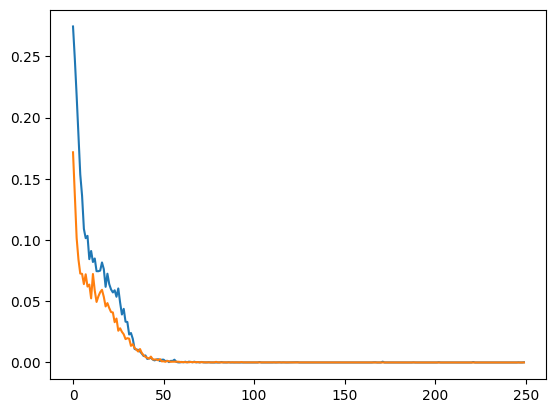

In [331]:
from matplotlib import pyplot as plt

plt.plot(net_losses)
plt.plot(alt_net_losses)
plt.show()